# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_048  A0A0C4DH34          18.422
Sample_201  A0A0B4J1V6          16.231
Sample_071  O75339              21.971
Sample_118  A0A0B4J2B5;S4R460   23.171
Sample_090  Q08174-2            17.170
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_114  Q504Y2           15.135
Sample_033  Q9BWS9           15.386
Sample_177  Q96FE7-4         18.393
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.461
            A0A075B6Q5                 11.866
            A0A075B6R2                 13.726
            A0A075B6S5                 12.638
            A0A087WSY4                 14.619
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.061
            Q9UI40;Q9UI40-2            12.350
            Q9UIW2                     13.053
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.652
            Q9UP79                     13.872
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.159,15.050,16.842,19.863,16.036,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.542,19.067,...,15.528,15.576,13.900,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.931,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.009,17.705,17.039,15.712,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.994,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.533,15.345,17.084,18.708,14.249,19.433,11.455,10.545
Sample_207,15.739,16.877,15.469,16.898,13.742,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.899,12.998,12.902,11.781,13.891,12.604,12.949,13.327,14.278,13.081
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.857,19.067,16.127,...,12.897,12.755,12.571,12.698,13.099,11.672,13.270,13.986,12.433,12.440
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.216,11.270,12.842,12.529,12.482,11.797,11.854,12.741,13.362,12.577
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.274,14.325,12.405,13.166,12.819,12.994,12.082,13.332,12.176,11.954
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.970,12.327,12.822,12.926,14.050,12.607,14.236,14.922,12.333,13.389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.572,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 180.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.57it/s]

100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

100%|██████████| 3/3 [00:00<00:00,  6.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]

100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.33it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.35it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.32it/s]

100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.86it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.00it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]

100%|██████████| 6/6 [00:01<00:00,  4.41it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.12it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.41it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.74it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.47it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.38it/s]

100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.72it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.67it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.14it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.80it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.70it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.76it/s]

100%|██████████| 8/8 [00:02<00:00,  2.77it/s]

100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.19it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.95it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.58it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.50it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.35it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.22it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.19it/s]

100%|██████████| 9/9 [00:03<00:00,  2.24it/s]

100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.11it/s]

 30%|███       | 3/10 [00:00<00:01,  5.73it/s]

 40%|████      | 4/10 [00:00<00:01,  4.99it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.75it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.24it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.05it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.15it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.28it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.83it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.42it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.96it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.57it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.29it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.35it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.12it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.11it/s]

100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

100%|██████████| 11/11 [00:02<00:00,  4.57it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.59it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.21it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.57it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.17it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.64it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.60it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.43it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.47it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.51it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.44it/s]

100%|██████████| 12/12 [00:02<00:00,  4.50it/s]

100%|██████████| 12/12 [00:02<00:00,  4.79it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.79it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.97it/s]

 31%|███       | 4/13 [00:00<00:01,  5.26it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.19it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.73it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.45it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.40it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.41it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.52it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.54it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.33it/s]

100%|██████████| 13/13 [00:02<00:00,  3.95it/s]

100%|██████████| 13/13 [00:02<00:00,  4.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.55it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.48it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.67it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.47it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.08it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.95it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.95it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.83it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.41it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.40it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.51it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.58it/s]

100%|██████████| 14/14 [00:03<00:00,  3.75it/s]

100%|██████████| 14/14 [00:03<00:00,  3.95it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.05it/s]

 20%|██        | 3/15 [00:00<00:02,  5.04it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.19it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.17it/s]

 40%|████      | 6/15 [00:01<00:02,  4.10it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.04it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.09it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.11it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.62it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.67it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.66it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.77it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.82it/s]

100%|██████████| 15/15 [00:03<00:00,  3.65it/s]

100%|██████████| 15/15 [00:03<00:00,  3.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.051 0.024          0.806 0.313       0.135   
2             0.004 0.002      0.046 0.017          0.606 0.130       0.472   
3             0.006 0.003      0.061 0.027          0.805 0.082       0.749   
4             0.004 0.001      0.039 0.005          0.794 0.083       0.775   
5             0.005 0.002      0.051 0.017          0.818 0.080       0.831   
6             0.005 0.003      0.061 0.023          0.823 0.081       0.823   
7             0.005 0.002      0.048 0.016          0.828 0.077       0.846   
8             0.007 0.005      0.071 0.038          0.832 0.077       0.846   
9             0.006 0.003      0.056 0.025          0.836 0.079       0.855   
10            0.003 0.001      0.033 0.011          0.815 0.071       0.847   
11            0.003 0.001      0.035 0.009          0.812 0.071       0.838   
12            0.003 0.001      0.033 0.007          0.820 0.076       0.839   
13            0.004 0.001      0.041 0.012          0.837 0.084       0.815   
14            0.004 0.001      0.042 0.011          0.837 0.080       0.809   
15            0.004 0.001      0.041 0.009          0.836 0.080       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.223 0.128                  0.560 0.041        0.850   
2          0.116   0.521 0.100                  0.619 0.069        0.698   
3          0.089   0.772 0.069                  0.807 0.056        0.916   
4          0.109   0.780 0.078                  0.813 0.065        0.920   
5          0.094   0.821 0.066                  0.846 0.057        0.921   
6          0.104   0.819 0.073                  0.845 0.062        0.921   
7          0.090   0.833 0.063                  0.857 0.055        0.922   
8          0.087   0.835 0.059                  0.858 0.052        0.921   
9          0.085   0.841 0.057                  0.863 0.051        0.921   
10         0.099   0.827 0.068                  0.853 0.059        0.923   
11         0.100   0.821 0.068                  0.847 0.058        0.920   
12         0.095   0.826 0.066                  0.851 0.057        0.918   
13         0.088   0.822 0.066                  0.848 0.056        0.924   
14         0.092   0.819 0.066                  0.846 0.055        0.921   
15         0.093   0.820 0.067                  0.846 0.056        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.823 0.089        210.000 0.000  
2          0.083                  0.650 0.099        210.000 0.000  
3          0.042                  0.905 0.042        210.000 0.000  
4          0.042                  0.903 0.046        210.000 0.000  
5          0.044                  0.909 0.045        210.000 0.000  
6          0.044                  0.910 0.045        210.000 0.000  
7          0.045                  0.914 0.044        210.000 0.000  
8          0.046                  0.913 0.043        210.000 0.000  
9          0.045                  0.913 0.042        210.000 0.000  
10         0.047                  0.915 0.044        210.000 0.000  
11         0.048                  0.910 0.047        210.000 0.000  
12         0.049                  0.908 0.049        210.000 0.000  
13         0.048                  0.915 0.047        210.000 0.000  
14         0.047                  0.912 0.048        210.000 0.000  
15         0.048                  0.909 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 449.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.64it/s]

100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

100%|██████████| 3/3 [00:00<00:00,  5.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.17it/s]

100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.13it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.16it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.46it/s]

100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.41it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.11it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

100%|██████████| 6/6 [00:01<00:00,  3.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.31it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.55it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.85it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.55it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.30it/s]

100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.68it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.19it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.59it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.07it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.92it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.95it/s]

100%|██████████| 8/8 [00:01<00:00,  3.77it/s]

100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.96it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.22it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.89it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.71it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.49it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.42it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.34it/s]

100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

100%|██████████| 9/9 [00:03<00:00,  2.61it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.23it/s]

 30%|███       | 3/10 [00:00<00:01,  5.49it/s]

 40%|████      | 4/10 [00:00<00:01,  4.73it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.36it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.04it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.17it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.83it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.68it/s]

100%|██████████| 10/10 [00:03<00:00,  2.48it/s]

100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.64it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.87it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.35it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.16it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.13it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.35it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.54it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.69it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.91it/s]

100%|██████████| 11/11 [00:04<00:00,  3.06it/s]

100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.70it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.43it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.07it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.94it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.86it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.77it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.67it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.18it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.86it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.68it/s]

100%|██████████| 12/12 [00:03<00:00,  2.59it/s]

100%|██████████| 12/12 [00:03<00:00,  3.23it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.37it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.94it/s]

 31%|███       | 4/13 [00:01<00:02,  3.36it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.31it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.18it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.80it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.54it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.44it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.59it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.67it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.88it/s]

100%|██████████| 13/13 [00:04<00:00,  2.76it/s]

100%|██████████| 13/13 [00:04<00:00,  2.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.47it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.58it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.38it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.14it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.00it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.32it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.26it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.26it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.35it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.44it/s]

100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.82it/s]

 20%|██        | 3/15 [00:00<00:03,  3.23it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.15it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.18it/s]

 40%|████      | 6/15 [00:01<00:02,  3.04it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.90it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.93it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.09it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.15it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.31it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.99it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.61it/s]

100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

100%|██████████| 15/15 [00:05<00:00,  2.94it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.040 0.008          0.120 0.291       0.014   
2             0.004 0.001      0.044 0.012          0.688 0.114       0.540   
3             0.004 0.000      0.038 0.005          0.821 0.074       0.731   
4             0.005 0.002      0.054 0.020          0.824 0.077       0.737   
5             0.006 0.002      0.059 0.019          0.788 0.081       0.726   
6             0.004 0.000      0.039 0.004          0.782 0.081       0.722   
7             0.002 0.000      0.023 0.003          0.808 0.096       0.796   
8             0.004 0.001      0.035 0.003          0.807 0.094       0.792   
9             0.004 0.001      0.035 0.008          0.807 0.088       0.795   
10            0.007 0.004      0.076 0.034          0.821 0.080       0.818   
11            0.005 0.003      0.047 0.019          0.820 0.076       0.813   
12            0.006 0.003      0.055 0.021          0.820 0.078       0.809   
13            0.005 0.002      0.049 0.016          0.818 0.076       0.805   
14            0.005 0.002      0.050 0.019          0.817 0.078       0.805   
15            0.006 0.003      0.065 0.029          0.832 0.083       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.017        0.869   
2          0.119   0.597 0.094                  0.677 0.065        0.750   
3          0.092   0.769 0.069                  0.807 0.054        0.883   
4          0.106   0.773 0.076                  0.810 0.058        0.881   
5          0.111   0.749 0.073                  0.790 0.056        0.883   
6          0.114   0.745 0.076                  0.786 0.059        0.880   
7          0.114   0.796 0.082                  0.827 0.068        0.906   
8          0.113   0.794 0.079                  0.825 0.065        0.903   
9          0.117   0.795 0.081                  0.827 0.066        0.902   
10         0.103   0.815 0.070                  0.843 0.059        0.917   
11         0.105   0.812 0.071                  0.841 0.059        0.916   
12         0.102   0.810 0.069                  0.839 0.058        0.914   
13         0.109   0.807 0.072                  0.836 0.059        0.913   
14         0.110   0.806 0.073                  0.835 0.061        0.916   
15         0.118   0.808 0.082                  0.838 0.066        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.833 0.087        210.000 0.000  
2          0.076                  0.685 0.101        210.000 0.000  
3          0.051                  0.841 0.074        210.000 0.000  
4          0.052                  0.842 0.074        210.000 0.000  
5          0.051                  0.849 0.068        210.000 0.000  
6          0.052                  0.845 0.070        210.000 0.000  
7          0.050                  0.882 0.064        210.000 0.000  
8          0.051                  0.879 0.064        210.000 0.000  
9          0.051                  0.876 0.066        210.000 0.000  
10         0.048                  0.897 0.060        210.000 0.000  
11         0.048                  0.896 0.060        210.000 0.000  
12         0.048                  0.892 0.064        210.000 0.000  
13         0.048                  0.890 0.065        210.000 0.000  
14         0.048                  0.896 0.061        210.000 0.000  
15         0.043                  0.908 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1040.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.24it/s]

100%|██████████| 3/3 [00:00<00:00, 21.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.02it/s]

100%|██████████| 4/4 [00:00<00:00,  9.49it/s]

100%|██████████| 4/4 [00:00<00:00,  9.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.98it/s]

100%|██████████| 5/5 [00:00<00:00, 13.96it/s]

100%|██████████| 5/5 [00:00<00:00, 14.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.65it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.23it/s]

100%|██████████| 6/6 [00:00<00:00, 13.29it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 14.27it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.69it/s]

100%|██████████| 7/7 [00:00<00:00, 12.10it/s]

100%|██████████| 7/7 [00:00<00:00, 12.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.70it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.61it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.30it/s]

100%|██████████| 8/8 [00:00<00:00, 10.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.64it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.12it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.70it/s]

100%|██████████| 9/9 [00:00<00:00, 12.46it/s]

100%|██████████| 9/9 [00:00<00:00, 13.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.45it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.99it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.65it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.09it/s]

100%|██████████| 10/10 [00:00<00:00, 12.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 16.15it/s]

 36%|███▋      | 4/11 [00:00<00:00, 13.89it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.09it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 12.03it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.06it/s]

100%|██████████| 11/11 [00:00<00:00, 12.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.02it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.91it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.38it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.50it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.73it/s]

100%|██████████| 12/12 [00:01<00:00, 11.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.23it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.53it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.96it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.78it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.38it/s]

100%|██████████| 13/13 [00:01<00:00, 12.42it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 28.67it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.71it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.51it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.15it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.60it/s]

100%|██████████| 14/14 [00:01<00:00, 11.31it/s]

100%|██████████| 14/14 [00:01<00:00, 12.54it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.83it/s]

 33%|███▎      | 5/15 [00:00<00:00, 17.79it/s]

 47%|████▋     | 7/15 [00:00<00:00, 16.99it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.94it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.65it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 11.12it/s]

100%|██████████| 15/15 [00:01<00:00, 11.19it/s]

100%|██████████| 15/15 [00:01<00:00, 12.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.048 0.019          0.000 0.000       0.000   
2             0.006 0.003      0.062 0.023          0.561 0.124       0.364   
3             0.004 0.001      0.042 0.014          0.590 0.106       0.401   
4             0.006 0.003      0.057 0.023          0.599 0.120       0.429   
5             0.004 0.001      0.037 0.010          0.620 0.116       0.458   
6             0.006 0.003      0.068 0.026          0.667 0.077       0.580   
7             0.004 0.001      0.040 0.010          0.666 0.081       0.580   
8             0.006 0.003      0.061 0.024          0.671 0.078       0.582   
9             0.004 0.002      0.038 0.007          0.651 0.081       0.626   
10            0.006 0.003      0.065 0.027          0.680 0.090       0.638   
11            0.004 0.002      0.040 0.015          0.668 0.088       0.628   
12            0.007 0.003      0.061 0.027          0.668 0.076       0.635   
13            0.005 0.003      0.049 0.022          0.660 0.076       0.631   
14            0.006 0.003      0.057 0.024          0.701 0.063       0.657   
15            0.006 0.003      0.058 0.024          0.692 0.068       0.652   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.103   0.431 0.094                  0.572 0.064        0.640   
3          0.090   0.471 0.081                  0.596 0.054        0.662   
4          0.098   0.493 0.092                  0.606 0.064        0.663   
5          0.094   0.520 0.086                  0.623 0.065        0.678   
6          0.099   0.615 0.073                  0.683 0.053        0.784   
7          0.101   0.615 0.073                  0.682 0.055        0.780   
8          0.103   0.618 0.072                  0.685 0.052        0.776   
9          0.109   0.633 0.078                  0.689 0.063        0.802   
10         0.113   0.652 0.084                  0.708 0.065        0.812   
11         0.117   0.641 0.083                  0.698 0.064        0.808   
12         0.125   0.645 0.087                  0.703 0.065        0.808   
13         0.121   0.639 0.084                  0.697 0.064        0.806   
14         0.112   0.674 0.074                  0.727 0.056        0.809   
15         0.116   0.666 0.078                  0.720 0.060        0.805   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.686 0.084        210.000 0.000  
2          0.081                  0.610 0.081        210.000 0.000  
3          0.074                  0.628 0.076        210.000 0.000  
4          0.079                  0.646 0.085        210.000 0.000  
5          0.082                  0.652 0.087        210.000 0.000  
6          0.055                  0.733 0.068        210.000 0.000  
7          0.057                  0.724 0.070        210.000 0.000  
8          0.058                  0.720 0.070        210.000 0.000  
9          0.059                  0.744 0.074        210.000 0.000  
10         0.057                  0.755 0.075        210.000 0.000  
11         0.056                  0.749 0.075        210.000 0.000  
12         0.054                  0.747 0.069        210.000 0.000  
13         0.055                  0.744 0.073        210.000 0.000  
14         0.054                  0.747 0.072        210.000 0.000  
15         0.055                  0.741 0.072 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,10,12
score_time,8,10,6
test_precision,14,15,14
test_recall,9,10,14
test_f1,9,10,14
test_balanced_accuracy,9,10,14
test_roc_auc,13,15,10
test_average_precision,13,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.10it/s]

 20%|██        | 3/15 [00:00<00:03,  3.84it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.22it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.81it/s]

 40%|████      | 6/15 [00:02<00:03,  2.62it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.56it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.57it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.65it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.77it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.85it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.92it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.12it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.33it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.29it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.00it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.58it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.66it/s]

100%|██████████| 10/10 [00:00<00:00, 12.39it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.82it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.28it/s]

 31%|███       | 4/13 [00:01<00:03,  2.89it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.96it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.04it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.14it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.17it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.07it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.09it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.98it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  2.75it/s]

100%|██████████| 13/13 [00:04<00:00,  3.00it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


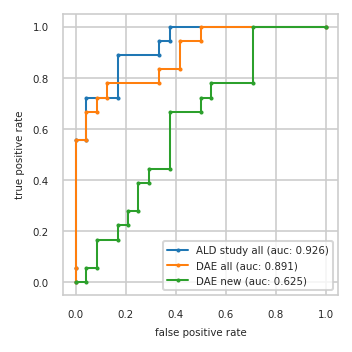

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.556   0.042 0.056
3          0.042 0.556   0.042 0.556   0.083 0.056
4          0.042 0.722   0.042 0.667   0.083 0.167
5          0.167 0.722   0.083 0.667   0.167 0.167
6          0.167 0.889   0.083 0.722   0.167 0.222
7          0.333 0.889   0.125 0.722   0.208 0.222
8          0.333 0.944   0.125 0.778   0.208 0.278
9          0.375 0.944   0.333 0.778   0.250 0.278
10         0.375 1.000   0.333 0.833   0.250 0.389
11         1.000 1.000   0.417 0.833   0.292 0.389
12           NaN   NaN   0.417 0.944   0.292 0.444
13           NaN   NaN   0.500 0.944   0.375 0.444
14           NaN   NaN   0.500 1.000   0.375 0.667
15           NaN   NaN   1.000 1.000   0.500 0.667
16           NaN   NaN     NaN   NaN   0.500 0.722
17           NaN   NaN     NaN   NaN   0.542 0.722
18           NaN   NaN     NaN   NaN   0.542 0.778
19           NaN   NaN     NaN   NaN   0.708 0.778
20           NaN   NaN     NaN   NaN   0.708 1.000
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,B0QYF8;P02144,Q9NX62,A0A0A0MSQ0;P13797;P13797-2;P13797-3
2,E7EUF1;Q13822-3,A0A1B0GV23;A0A1B0GVD5;A0A1B0GWE8;P07339,A0A087WSY4
3,P14174,P14174,P31321
4,P61981,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P04075,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P01597;P04432,P04075,Q96GD0
7,P05413;S4R371,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,Q9Y2T3;Q9Y2T3-3,P63104,Q9NUQ9


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


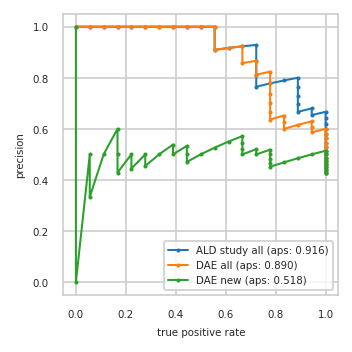

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.630 0.944     0.519 0.778
16         0.654 0.944     0.615 0.889     0.500 0.722
17         0.680 0.944     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.652 0.833     0.522 0.667
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.762 0.889     0.667 0.778     0.571 0.667
22         0.800 0.889     0.700 0.778     0.550 0.611
23         0.789 0.833     0.737 0.778     0.526 0.556
24         0.778 0.778     0.778 0.778     0.500 0.500
25         0.765 0.722     0.824 0.778     0.471 0.444
26         0.812 0.722     0.812 0.722     0.500 0.444
27         0.867 0.722     0.867 0.722     0.533 0.444
28         0.929 0.722     0.857 0.667     0.500 0.389
29         0.923 0.667     0.923 0.667     0.538 0.389
30         0.917 0.611     0.917 0.611     0.500 0.333
31         0.909 0.556     0.909 0.556     0.455 0.278
32         1.000 0.556     1.000 0.556     0.500 0.278
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


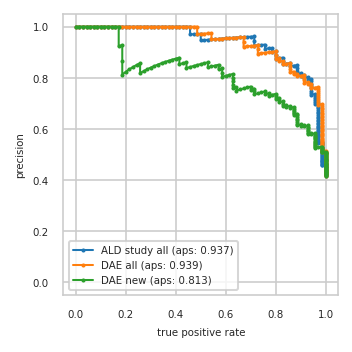

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


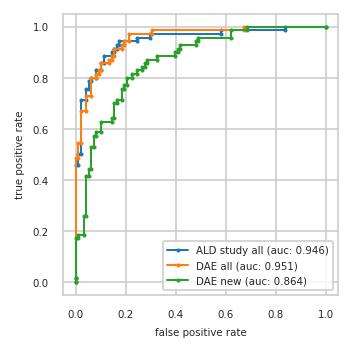

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}